# Multi-label Classification

In this exercise we will classify toxic comments from online. 

In [1]:
%matplotlib inline
import re
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from nltk.corpus import stopwords


In [2]:
# Store English stopwords in "stop_words" var
stop_words = set(stopwords.words('english'))


# Data loading

In [3]:
df = pd.read_csv("/dsa/data/DSA-8410/toxic/train.csv", encoding = "ISO-8859-1")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Data exploration

### T1. Show a distribution of comments over toxic categoies.

In [4]:
# Drop comments & id columns and store in temp df
df_tmp = df.drop(['comment_text', 'id'], axis=1)

# Instantiate empty list
counts = []

# Assign column names to "categories" var
categories = list(df_tmp.columns.values)

# Step through the categories and sum up all the comments
for i in categories:
    counts.append((i, df_tmp[i].sum()))
    
# Create new df from the categories and count of occurrences
df_stats_1 = pd.DataFrame(counts, columns=['toxic_categories', 'number_of_comments'])
#df_stats_1


Text(0.5, 0, 'Categories')

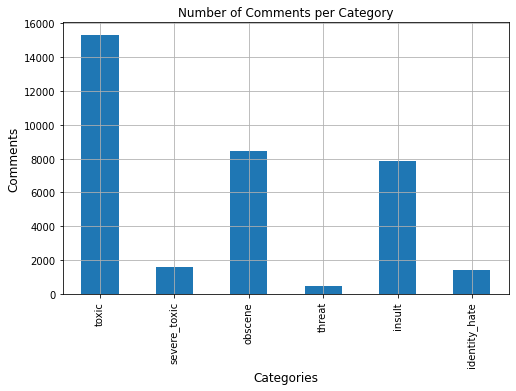

In [5]:
# Plot number of comments by toxic category
df_stats_1.plot(x='toxic_categories', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of Comments per Category")
plt.ylabel('Comments', fontsize=12)
plt.xlabel('Categories', fontsize=12)


### T2. Show a distribution of number of toxic categories per comment

array([[<AxesSubplot:title={'center':'categories_per_comment'}>]],
      dtype=object)

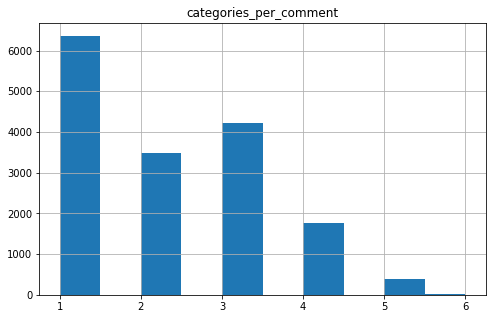

In [6]:
# Count number of toxic categories per comment
'''rowsums = df.iloc[:,1:].sum(axis=1)
x = rowsums.value_counts()
x'''

df['categories_per_comment'] = df.sum(axis=1)
#df_tmp_2 = df_cat_per_comm.iloc[:,-1:]
df_tmp_2 = df.loc[~((df['categories_per_comment'] == 0))]
              
df_tmp_2.hist(column='categories_per_comment', bins = 10, figsize=(8, 5))


### T3. Show a distribution of comment lenght in terms of characters

array([[<AxesSubplot:title={'center':'comment_length'}>]], dtype=object)

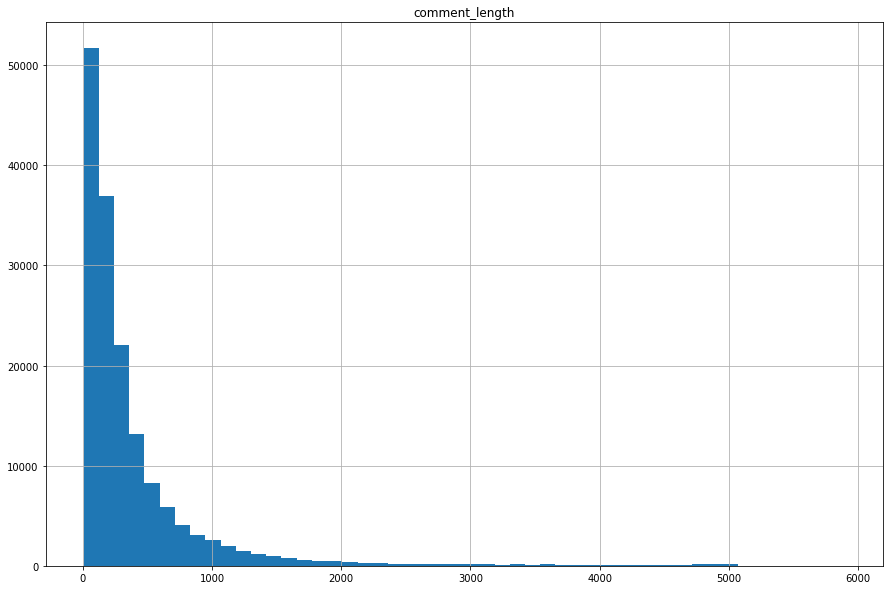

In [7]:
# Count length of comments
df['comment_length'] = df['comment_text'].str.len()
#df
'''df_tmp_3 = df.loc[~((df['comment_length'] == 0))]
df_tmp_3'''
df.hist(column='comment_length', bins = 50, figsize=(15, 10))


### T4. Show five randomly picked comments

In [8]:
# Randomly display 5 comments
for i in range(5): 
    # Store random (from validation data) sample's index in "k" var
    k = df.sample(1).index[0]
    print(f"\nRandom comment", k, ":")
    print(df['comment_text'][k], "\n")
    print("=============================================================================================")


Random comment 86047 :
Copyright
Just to let you know I responded to your question on my talk page 


Random comment 38842 :
What about this 20 year FBI vet:http://www.youtube.com/watch?v=DhMcii8smxk

O wow what a coincidence these CIA & FBI agents admit to having their investigations into Bin Laden s whereabouts cut short after they got close to him, I guess they are crazy conspiracy theorists.

http://www.youtube.com/watch?v=R-Da9ghk-sk 


Random comment 37195 :
Ya, and it means you deleted the abuse I reported, and warned me, except he deleted my contribution without examining the website, deleting all that work, so I got pissed and left a comment on his page, another user left a comment on my page saying it was uncivil, I agreed and was going to drop it, until Kww came to my user page and started making threats. That abuse file was justified, he abusing his admin privilages for a power trip, like some sort of facist police officer, and if you analyze his contributions, there are m

# Text cleaning

Let's use the following funciton as a black box for text cleaning. 

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### T5. Apply the above function and clean the comment texts. 

In [10]:
# Clean up text
df['tidy_comment'] = df['comment_text'].apply(lambda x: clean_text(x))

# Function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# Call function to remove stopwords
df['tidy_comment'] = df['tidy_comment'].apply(lambda x: remove_stopwords(x))
#df.head()


In [ ]:
'''# an empty list
comments = []

# extract comments
for i in df['tidy_comment']: 
  comments.append(list((i)))
 
# add to dataframe  
df['tidy_comment_new'] = comments'''

In [ ]:
'''# Drop rows with no comment
df_new = df[~(df['tidy_comment_new'].str.len()==0)]
df_new.shape, df.shape'''


In [ ]:
'''# get all comment tags in a list
all_comments = sum(comments,[])
len(set(all_comments))'''


In [40]:
'''all_comments = nltk.FreqDist(all_comments) 

# create dataframe
all_comments_df = pd.DataFrame({'Genre': list(all_comments.keys()), 
                              'Count': list(all_comments.values())})

g = all_comments_df.nlargest(columns="Count", n = 50) 

plt.figure(figsize=(12,15)) 
ax = sns.barplot(data = g, x = "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()'''

'''temp_comments = []

for i in movies['tidy_comments']:
    temp_comments.append(list(set(i).intersection(set(selected_genre))))'''

'''# Remove all rows with no 
df_new = df.loc[~((df['categories_per_comment'] == 0))]'''


"# Remove all rows with no \ndf_new = df.loc[~((df['categories_per_comment'] == 0))]"

# Model development

### T6. Split data into train (80%) and test (20%)

In [58]:
'''one_v_rest = OneVsRestClassifier()
# Fit binarizer to tidied up comments
one_v_rest.fit(df['tidy_comment'])

# Transform tidied up comments
y = one_v_rest.transform(df['tidy_comment'])

# Store a TfidfVectorizer that ignores top 30% producing binary vector of 100 digits
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=100)'''

'''# Instantiate empty list
counts = []'''

'''# Assign column names to "categories" var
categories = list(df_temp.columns.values)
categories'''

'''categories[]
for i in df_new['genre']: 
  genres.append(list(json.loads(i).values()))'''

# Create empty list
toxicCategories = []

# Remove rows with no toxic comments 
df_new = df[~(df['categories_per_comment'] == 0)]

# Drop comments & id columns and store in temp df
df_temp = df_new.drop(['id', 'comment_text', 'categories_per_comment', 'comment_length', 'tidy_comment'], axis=1)

# Create column with toxic categories each comment garners
df_temp['toxic_categories'] = (df_temp.iloc[:,:-1] > 0).apply(lambda x: ','.join([col for cond, col in zip(x,df_temp.columns) if cond]), axis=1)

# Convert delimited text into a list of values
df_temp['toxic_categories'] = df_temp['toxic_categories'].str.split(',', n = 1, expand = False)

# Extract categories as a list
#toxicCategories = list(df_temp['toxic_categories'])
toxicCategories = df_temp["toxic_categories"].values.tolist()

# Add to dataframe
df_new['toxic_categories'] = toxicCategories
#df_new

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
'''# Create number of categories tags
y = [0,1,2,3,4,5,6]'''

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_new['toxic_categories'])

# transform target variable
y = multilabel_binarizer.transform(df_new['toxic_categories'])

# Store a TfidfVectorizer that ignores top 30% producing binary vector of 100 digits
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=100)

# Create training a validation datasets
xtrain, xval, ytrain, yval = train_test_split(df_new['tidy_comment'], y, 
                                              test_size = 0.2, random_state = 17)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) 
xval_tfidf = tfidf_vectorizer.transform(xval)

### T7. Define and train a multi-label (aka multioutput) classifier. Pick a suitable classifier as a base estimator. 

In [63]:
# Instantiate , wrapped by MultiOutputClassifier all fit to training data
clf = MultiOutputClassifier(MultinomialNB()).fit(xtrain_tfidf, ytrain)
# Predict y based on x validation data
y_pred = clf.predict(xval_tfidf)


### T8. Estimate accuracy

In [64]:
accuracy = np.sum(y_pred  == yval) / (yval.shape[0] * yval.shape[1])
print(f"Acc: {accuracy:.2}")


Acc: 0.96


## T9. Qualitative evaluation: Create a subset of comments where the number of predicted tags is three. Take the first ten comments and show their text, true toxic categories, and predicted categories. Write a brief comment about your observations.

In [89]:
lol = y_pred == 3
maybe['pred_check'] = df_new
check

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [84]:

def infer_tags(q):
    # Clean text via custom function clean_text() and store in "q" var
    q = clean_text(q)
    # Remove stopwords
    q = remove_stopwords(q)
    # Turn text into binary vector
    q_vec = tfidf_vectorizer.transform([q])
    # Predict based on binary vector
    q_pred = clf.predict(q_vec)
    # Transform predicted binary vector to text and return text to calling function
    return multilabel_binarizer.inverse_transform(q_pred)

# Randomly pick 10 comments
for i in range(10): 
    # Store random sample's index in "k" var
    k = xval.sample(1).index[0]
    print("Comment:", df_qe['comment_text'][k], "\nPredicted number of categories:", infer_tags(xval[k])), 
    print("Actual number of categories:", df_qe['toxic_categories'][k], "\n")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Save your notebook, the `File > Close and Halt`